# Brain tumor Classification and Segmentation

### Une tumeur cérébrale représente un ensemble de cellules anormales qui se reproduisent dans le cerveau de manière incontrôlée. Les tumeurs cérébrales sont classées en fonction de leur vitesse de croissance et de leur probabilité de repousser après le traitement.Les tumeurs de grade 1 et 2 sont de bas grade et les tumeurs de grade 3 et 4 sont de haut grade.
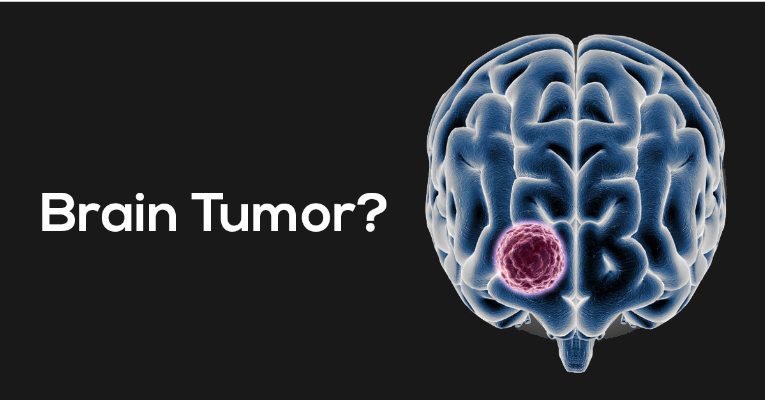


## Contexte IRM
L'imagerie par résonance magnétique (IRM) est l'outil de diagnostic le plus courant des tumeurs cérébrales, principalement en raison de sa nature non invasive et de sa capacité à imager divers types de tissus et processus physiologiques. L'IRM utilise un gradient magnétique et des impulsions de radiofréquence pour prendre des tranches axiales répétitives du cerveau et construire une représentation tridimensionnelle. Chaque cerveau scanne 155 tranches, chaque pixel représentant un voxel de 1 mm3.
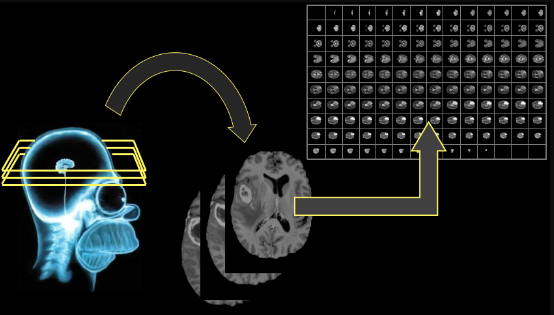

# ***Classification***

### L'objectif principal de ce projet était de construire un modèle CNN qui classifierait si le sujet a une tumeur ou non sur la base d'une IRM.
Les données d'image qui ont été utilisées pour ce problème sont des images d'IRM cérébrales pour la détection de tumeurs cérébrales. Il se compose d'examens IRM de deux classes :

*   NON - pas de tumeur
*   OUI - tumeur

*Setting up the environment*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

*Import libraries needed*



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob
from google.colab import files

In [ ]:
! pip install -q kaggle
os.getcwd()

## **Brain Cancer MRI DATASET ANASLYSIS**


Préparer l'ensemble de données

In [ ]:
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

In [ ]:
!kaggle datasets download -d tahaelkhayaty/brain-tumor-data

In [ ]:
!kaggle datasets download -d tahaelkhayaty/vgg-weights-16

In [ ]:
! mkdir vgg
! unzip /content/vgg-weights-16.zip -d vgg-weight


*Compter le nombre d'images dans les classes respectives  0-brain tumor  1-healthy*

In [ ]:

ROOT_DIR="/content/3_brain-tumor-data/Data_classification"
os.chdir(ROOT_DIR)
number_of_images={}

for dir in os.listdir(ROOT_DIR):
  number_of_images[dir]=len(os.listdir(os.path.join(ROOT_DIR,dir)))
    

number_of_images

*À l'heure actuelle, toutes les images sont dans un dossier avec des sous-dossiers oui et non.Nous diviserons maintenant les données telles que nous avons 70 % pour training, 15 % pour validation et 15 % pour testing.*

In [ ]:

def datafolder(p,split,selected_images):
    if not os.path.exists("./"+p):
        os.mkdir("./"+p)
        number_of_images={}
        for dir in ["tumor","no_tumor"]:
            os.makedirs("./"+p+"/"+dir)
            
            a=set(os.listdir(os.path.join(ROOT_DIR,dir)))-selected_images[dir]
            number_of_images[dir]=len(a)
            liste=np.random.choice(list(a), size=math.floor(split*number_of_images[dir]),replace=False)
            print(len(liste))
            for img in liste:
              origin=os.path.join(ROOT_DIR,dir,img)
              destination=os.path.join("./"+p,dir)
              shutil.copy(origin,destination)
            selected_images[dir]=selected_images[dir].union(liste)
        return selected_images
    else:
        print(f"{p}folder already exists")
        
        

In [ ]:
p=datafolder("train",0.7,{"tumor":set(),"no_tumor":set()})
print(len(p["tumor"]),len(p["no_tumor"]))

In [ ]:
q=datafolder("validation",0.5,p)
print(len(q["tumor"]),len(q["no_tumor"]))

In [ ]:
t=datafolder("test",1,q)
print(len(t["tumor"]),len(t["no_tumor"]))

### **Construction de maquettes (Model Building)**

*Importing the necessary libraries*

In [ ]:
import tensorflow 
import keras
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten,Dense,BatchNormalization, GlobalAvgPool2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import load_img, img_to_array

from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

In [ ]:
model=Sequential()

model.add(Conv2D(filters=16 , kernel_size= (3,3), activation= 'relu', input_shape=(224,224,3) ))

model.add(Conv2D(filters=36 , kernel_size= (3,3), activation= 'relu' ))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64 , kernel_size= (3,3), activation= 'relu' ))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=128 , kernel_size= (3,3), activation= 'relu' ))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

In [ ]:
model.compile(optimizer='adam', loss= keras.losses.binary_crossentropy, metrics=['accuracy'])

**Data Augmentation**
Comme nous avons un petit ensemble de données, nous avons utilisés la technique appelée Data Augmentation qui aide à "augmenter" la taille de l'ensemble d'entraînement grace à la fonctionnalité *ImageDataGenerator*.
rescale est une valeur par laquelle nous multiplierons les données avant tout autre traitement. Nos images d'origine consistent en des coefficients RVB dans le 0-255, mais de telles valeurs seraient trop élevées pour que nos modèles puissent les traiter (étant donné un taux d'apprentissage typique), nous ciblons donc des valeurs entre 0 et 1 à la place en mettant à l'échelle avec un 1/255. facteur.

In [ ]:
def preprocessingImages1(path):
    

    '''
    input : Path
    output : Pre processed images
    '''
    image_data = ImageDataGenerator(zoom_range=0.2, shear_range=0.2, rescale=1/255, horizontal_flip=True) #data augmentation
    image = image_data.flow_from_directory(directory=path, target_size=(224,224), batch_size=32, class_mode='binary')
    return image
    

In [ ]:
train_path='/content/3_brain-tumor-data/Data_classification/train'
train_data=preprocessingImages1(train_path)

In [ ]:
def preprocessingImages2(path):
    

    '''
    input : Path
    output : Pre processed images
    
    '''
    image_data = ImageDataGenerator(rescale=1/255)
    image = image_data.flow_from_directory(directory=path, target_size=(224,224), batch_size=32, class_mode='binary')
    return image
    

In [ ]:
test_path='/content/3_brain-tumor-data/Data_classification/test'
test_data= preprocessingImages2(test_path)

In [ ]:
val_path='/content/3_brain-tumor-data/Data_classification/validation'
val_data= preprocessingImages2(val_path)

In [ ]:
# early stopping and model check point

from keras.callbacks import ModelCheckpoint, EarlyStopping

# early stopping

es=EarlyStopping(monitor="val_accuracy", min_delta=0.01, patience=6, verbose=1, mode='auto')

#model check point

mc=ModelCheckpoint(monitor="val_accuracy", filepath="./bestmodel.h5", verbose=1, save_best_only=True, mode='auto')

cd=[es,mc]

## **Model Training**

In [ ]:
hs = model.fit_generator(generator=train_data, steps_per_epoch=20, epochs=40, verbose=1, validation_data=val_data, validation_steps=16, callbacks=cd)

In [ ]:
# Model graphical interpretation

h = hs.history
h.keys()

In [ ]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c="red")

plt.title("acc vs val_acc")
plt.show()

In [ ]:
plt.plot(h['loss'])
plt.plot(h['val_loss'], c="red")

plt.title("loss vs val_loss")
plt.show()

In [ ]:
# Model Accuracy

from keras.models import load_model

model = load_model("./bestmodel.h5")

## **Model Accuracy**

In [ ]:
acc=model.evaluate(test_data)[1]

print(f"the accuracy of the model is {acc*100} %")

In [ ]:
train_data.class_indices

In [ ]:
path="/content/3_brain-tumor-data/Data_classification/no_tumor/0006.tif"
img=load_img(path, target_size=(224,224))
input_arr=img_to_array(img)/255

plt.imshow(input_arr)
plt.show()

input_arr.shape
input_arr=np.expand_dims(input_arr, axis=0)


pred=(model.predict(input_arr)[0][0]> 0.5).astype("int32")


pred
if pred==1:
    print("this patient is having a Tumor")
else:
    print("this patient is not having a Tumor")


## **Conclusion:**
La première partie projet était une combinaison du problème de classification du modèle CNN (pour prédire si le sujet a une tumeur au cerveau ou non) . La précision (accuracy) finale du modèle est à peu près de 78.14 %. Cependant, il pourrait être augmenté par un plus grand nombre d'images de train ou par le réglage des hyperparamètres du modèle.

### **VGG16**

In [ ]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path +'/'+ path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [ ]:
TRAIN_DIR = '/content/3_brain-tumor-data/Data_classification/train/'
TEST_DIR = '/content/3_brain-tumor-data/Data_classification/test/'
VAL_DIR = '/content/3_brain-tumor-data/Data_classification/validation/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train2, y_train2, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test2, y_test2, _ = load_data(TEST_DIR, IMG_SIZE)
X_val2, y_val2, _ = load_data(VAL_DIR, IMG_SIZE)

In [ ]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train2, y_val2, y_test2):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [ ]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

In [ ]:
plot_samples(X_train2, y_train2, labels, 10)

In [ ]:
RATIO_LIST = []
for set in (X_train2, X_test2, X_val2):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

In [ ]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    impo=0
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        cnts = imutils.grab_contours(cnts)
        if (len(cnts)==0):
          cnts=cnts_pre
        else:
          c = max(cnts, key=cv2.contourArea)
          cnts_pre=c

        

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)


In [ ]:
img = cv2.imread('/content/3_brain-tumor-data/Data_classification/tumor/0013.tif')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [ ]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train2)
X_val_crop = crop_imgs(set_name=X_val2)
X_test_crop = crop_imgs(set_name=X_test2)

In [ ]:
plot_samples(X_train_crop, y_train2, labels, 10)

In [ ]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [ ]:
# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train2, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val2, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test2, folder_name='TEST_CROP/')

In [ ]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [ ]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

In [ ]:
 plot_samples(X_train_prep, y_train2, labels, 10)

In [ ]:
# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [ ]:
os.mkdir('preview')
x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break

In [ ]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [ ]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'
RANDOM_SEED=123
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

In [ ]:
# plot feature map of first conv layer for given image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
#from keras.preprocessing.image import load_img
#from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot 
from numpy import expand_dims


f = plt.figure(figsize=(16,16))
# load the modelf = plt.figure(figsize=(10,3))
model = VGG16()
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[1].output)
model.summary()
# load the image with the required shape
# convert the image to an array
img = img_to_array(X_val_prep[43])
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
#img = cv2.resize(img, dsize=IMG_SIZE,interpolation=cv2.INTER_CUBIC)
feature_maps = model.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='viridis')
		ix += 1
# show the figure
pyplot.show()

In [ ]:
# load base model
vgg16_weight_path = '/content/3_brain-tumor-data/vgg-weight/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
vgg = VGG16(
    weights=vgg16_weight_path,
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

In [ ]:
NUM_CLASSES = 1

vgg16 = Sequential()
vgg16.add(vgg)
vgg16.add(layers.Dropout(0.3))
vgg16.add(layers.Flatten())
vgg16.add(layers.Dropout(0.5))
vgg16.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

vgg16.layers[0].trainable = False

vgg16.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)
vgg16.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=["accuracy"])

vgg16.summary()

In [ ]:
# visualize feature maps output from each block in the vgg model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
import matplotlib.pyplot as plt
from numpy import expand_dims




# load the model
model = VGG16()
# redefine model to output right after the first hidden layer
ixs = [2, 5, 9, 13, 17]
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
# load the image with the required shape
# convert the image to an array
img = img_to_array(X_val_prep[43])
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot the output from each block
square = 8
for fmap in feature_maps:
	# plot all 64 maps in an 8x8 squares
	ix = 1
	for _ in range(square):
		plt.figure(figsize=(64,64))
		for _ in range(square):
           

			# specify subplot and turn of axis
			ax = pyplot.subplot(square, square, ix)
			ax.set_xticks([])
			ax.set_yticks([])
			
			# plot filter channel in grayscale
			plt.imshow(fmap[0, :, :, ix-1], cmap='viridis')
			ix += 1
	# show the figure

        
	plt.show()

In [ ]:
import time

start = time.time()

vgg16_history = vgg16.fit_generator(
    train_generator,
    steps_per_epoch=25,
    epochs=60,
    validation_data=validation_generator,
    validation_steps=30,
)


end = time.time()
print(end - start)

In [ ]:
# validate on val set
predictions = vgg16.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

_, train_acc = vgg16.evaluate(X_val_prep, y_val2, verbose=0)
_, test_acc = vgg16.evaluate(X_test_prep, y_test2, verbose=0)

In [ ]:
vgg16_history.history.keys()

In [ ]:
pyplot.figure(figsize=(12,12))
# plot loss during training
pyplot.subplot(211)
pyplot.title('Vgg16 Loss')
pyplot.plot(vgg16_history.history['loss'], label='train')
pyplot.plot(vgg16_history.history['val_loss'], label='Validation')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Vgg16 Accuracy')
pyplot.plot(vgg16_history.history['accuracy'], label='train')
pyplot.plot(vgg16_history.history['val_accuracy'], label='Validation')
pyplot.legend()
pyplot.show()


In [ ]:
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test2, predictions)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test2, predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test2, predictions)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test2, predictions)
print('F1 score: %f' % f1)
confusion_mtx = confusion_matrix(y_test2, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [ ]:
kappa = cohen_kappa_score(y_test2, predictions)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test2, predictions)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test2, predictions)
print(matrix)

# **Segmentation**

 

*   L'objectif de la segmentation sémantique des images est d'étiqueter chaque pixel d'une image avec une classe correspondante de ce qui est représenté. Étant donné que nous prévoyons pour chaque pixel de l'image, cette tâche est communément appelée prédiction dense.

*Setting up the environment & importing libraries needed*

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#from utils import *
#from unet import *


In [ ]:
os.getcwd()

**Loading the image and mask\:**

In [ ]:
ROOT_DIR_IM="/content/3_brain-tumor-data/Data_segmentation/images/images"
ROOT_DIR_MA="/content/3_brain-tumor-data/Data_segmentation/masks/masks"
im = os.listdir(ROOT_DIR_IM)
ma = os.listdir(ROOT_DIR_MA)
image_filenames_train=[]
mask_files=[]
for i in range(len(im)):
  image_filenames_train.append(os.path.join(ROOT_DIR_IM,im[i]))
  mask_files.append(os.path.join(ROOT_DIR_MA,im[i]))


lenght=len(mask_files)


In [ ]:
lenght

In [ ]:
def plot_from_img_path(rows, columns, list_img_path, list_mask_path):
    fig = plt.figure(figsize=(12, 12))
    for i in range(1, rows * columns + 1, 2):
      fig.add_subplot(rows, columns, i)
      r=np.random.randint(0, lenght )
      img_path = list_img_path[r]
      mask_path = list_mask_path[r]
      mask = cv2.imread(mask_path)
      image = cv2.imread(img_path)
      #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      
      plt.subplot(rows, columns, i)
      plt.imshow(mask)
      if (i < rows*columns):
        plt.subplot(rows, columns, i+1)
        plt.imshow(image)
      plt.show()

In [ ]:
plot_from_img_path(3,3, image_filenames_train, mask_files)

**Create data frame and split data on train set, validation set and test set**

In [ ]:
df = pd.DataFrame(data={'image_filenames_train': image_filenames_train, 'mask': mask_files })

df_train, df_test = train_test_split(df, test_size=0.1)

# Further split this val and train
df_train, df_val = train_test_split(df_train, test_size=0.2)

print(df_train.shape)
print(df_test.shape)
print(df_val.shape)


## **Data genertator, data augmentation and adjust data**

L'augmentation des données est une technique d'augmentation artificielle de l'ensemble training en créant des copies modifiées d'un ensemble de données à l'aide de données existantes. Cela inclut d'apporter des modifications mineures à l'ensemble de données ou d'utiliser deep learning pour générer de nouveaux points de données.

In [ ]:
# Referring Code From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,
):
    """
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    """
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_filenames_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)
    
    # Final return Tuple after image Normalization and Diagnostics
    for (img, mask) in train_gen:
        img, mask = normalize_and_diagnose(img, mask)
        yield (img, mask)


Après la normalisation du masque, si la valeur est <= 0,5, alors ce masque sera considéré comme un masque noir complet et n'a pas de tumeur.

In [ ]:

def normalize_and_diagnose(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return(img, mask)


Dans cette segmentation sémantique on a utulisée deux métriques qui sont extrêmement efficace:


*  Le Dice coefficient est égal à 2 * la zone de chevauchement divisée par le nombre total de pixels dans les deux images.
*  L'Intersection-Over-Union (IoU), également connu sous le nom d'indice Jaccard est la zone de chevauchement entre la segmentation prédite et la vérité terrain divisée par la zone d'union entre la segmentation prédite et la vérité terrain

In [ ]:
def dice_coefficients(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)


def dice_coefficients_loss(y_true, y_pred, smooth=100):
    return -dice_coefficients(y_true, y_pred, smooth)

def iou(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

def jaccard_distance(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    return -iou(y_true_flatten, y_pred_flatten)

L’un des réseaux de neurones les plus utilisés pour la segmentation d’image est **U-NET**. Il s’agit d’un Modèle de Réseau de Neurones Entièrement Convolutif. 

L’architecture de U-NET est composée de deux chemins:

*   Le premier est le chemin de contraction, aussi appelé encodeur. Il est utilisé pour capturer le contexte d’une image.Il s’agit en fait d’un assemblage de couches de convolution et de couches de  » max pooling  » permettant de créer une carte de caractéristiques d’une image et de réduire sa taille pour diminuer le nombre de paramètres du réseau.
*   Le second chemin est celui de l’expansion symétrique, aussi appelé décodeur. Il permet aussi une localisation précise grâce à la convolution transposée.

In [ ]:
def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # First DownConvolution / Encoder Leg will begin, so start with Conv2D
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(inputs)
    bn1 = Activation("relu")(conv1)
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation("relu")(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(pool1)
    bn2 = Activation("relu")(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation("relu")(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(pool2)
    bn3 = Activation("relu")(conv3)
    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation("relu")(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(pool3)
    bn4 = Activation("relu")(conv4)
    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation("relu")(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(pool4)
    bn5 = Activation("relu")(conv5)
    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation("relu")(bn5)

    """ Now UpConvolution / Decoder Leg will begin, so start with Conv2DTranspose
    The gray arrows (in the above image) indicate the skip connections that concatenate the encoder feature map with the decoder, which helps the backward flow of gradients for improved training. """
    up6 = concatenate(
        [
            Conv2DTranspose(512, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn5
            ),
            conv4,
        ],
        axis=3,
    )
    """ After every concatenation we again apply two consecutive regular convolutions so that the model can learn to assemble a more precise output """
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(up6)
    bn6 = Activation("relu")(conv6)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation("relu")(bn6)

    up7 = concatenate(
        [
            Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn6
            ),
            conv3,
        ],
        axis=3,
    )
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(up7)
    bn7 = Activation("relu")(conv7)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation("relu")(bn7)

    up8 = concatenate(
        [
            Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn7
            ),
            conv2,
        ],
        axis=3,
    )
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(up8)
    bn8 = Activation("relu")(conv8)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation("relu")(bn8)

    up9 = concatenate(
        [
            Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn8
            ),
            conv1,
        ],
        axis=3,
    )
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(up9)
    bn9 = Activation("relu")(conv9)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation("relu")(bn9)

    conv10 = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
im_height, im_width= 256,256
EPOCHS = 25
BATCH_SIZE = 32
learning_rate = 1e-4
smooth=100

In [ ]:
train_generator_param = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_param,
                                target_size=(im_height, im_width))
    
test_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
    
model = unet(input_size=(im_height, im_width, 3))



decay_rate = learning_rate / EPOCHS

opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)

model.compile(optimizer=opt, loss=dice_coefficients_loss, metrics=["binary_accuracy", iou, dice_coefficients])

callbacks = [ModelCheckpoint('unet.hdf5', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gen,
                    validation_steps=len(df_val) / BATCH_SIZE)


In [ ]:
history.history.keys()

In [ ]:
history_post_training = history.history

train_dice_coeff_list = history_post_training['dice_coefficients']
test_dice_coeff_list = history_post_training['val_dice_coefficients']

train_jaccard_list = history_post_training['iou']
test_jaccard_list = history_post_training['val_iou']

train_loss_list = history_post_training['loss']
test_loss_list = history_post_training['val_loss']

plt.figure(1)
plt.plot(test_loss_list, 'b-')
plt.plot(train_loss_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('loss graph', fontsize=12)

plt.figure(2)
plt.plot(train_dice_coeff_list, 'b-')
plt.plot(test_dice_coeff_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.title('Accuracy graph', fontsize=12)
plt.show()


Load previously trained Model
**texte en gras**

In [ ]:
model = load_model('unet.hdf5', custom_objects={'dice_coefficients_loss': dice_coefficients_loss, 'iou': iou, 'dice_coefficients': dice_coefficients  } )


In [ ]:
test_gen = train_generator(df_test, BATCH_SIZE, dict(), target_size=(im_height, im_width)  )

results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE )

print('Test Loss ', results[0] )
print('Test IoU ', results[1] )
print('Test Dice Coefficient ', results[2] )

**Plotting Predicted Masks Segmentation results from the Test Image set**

In [ ]:
for i in range(20):
    index = np.random.randint(1, len(df_test.index))
    img = cv2.imread(df_test['image_filenames_train'].iloc[index])
    img = cv2.resize(img, (im_height, im_width))
    img = img/255
    # print(imgs.shape) (256, 256 , 3)
    img = img[np.newaxis, :, :, : ]
    # print(img.shape) # (1, 256, 256, 3)

    predicted_img = model.predict(img)
    
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.show()

# **Conclusion:**
Puisque la valeur finale du test IOU est égale à 99,75% , donc on peut conclure que les résultats de la segmentation sémantique sont assez performants et efficaces.